In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Flatten, Conv2D, TimeDistributed

In [37]:
# Parámetros 
future_steps = 6
height, width, channels = 480, 480, 3 

In [38]:
# Obtener el número total de imágenes
image_folder = 'Images/ACMF/'
forecast_folder = 'Images/Forecast/'
os.makedirs(forecast_folder, exist_ok=True)  # Crear el folder 'Images/Forecast' si no existe
image_files = sorted([f'Images/ACMF/{i}' for i in os.listdir(image_folder) if i.endswith('.png')])
sequence_length = 138

if sequence_length <= 0:
    raise ValueError("No hay suficientes imágenes para formar secuencias con los parámetros dados.")

print(f"Número total de archivos de imagen: {len(image_files)}")
print(f"sequence_length: {sequence_length}, future_steps: {future_steps}")

Número total de archivos de imagen: 144
sequence_length: 138, future_steps: 6


In [39]:
# Función para cargar y preprocesar imágenes
def load_and_preprocess_image(image_path, target_size=(height, width)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No se puede leer la imagen: {image_path}")
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # Normalizacion RGB
    return image

# Función para cargar secuencias de imágenes
def load_image_sequences(folder, sequence_length, future_steps):
    X = []
    y = []
    image_files = sorted([f'Images/ACMF/{i}' for i in os.listdir(folder) if i.endswith('.png')])
    
    for i in range(0, len(image_files) - sequence_length - future_steps + 1):
        sequence_images = []
        future_images = []

        for j in range(sequence_length):
            image_path = image_files[i + j]
            image = load_and_preprocess_image(image_path, target_size=(height, width))
            sequence_images.append(image)

        for k in range(sequence_length, sequence_length + future_steps):
            image_path = image_files[i + k]
            image = load_and_preprocess_image(image_path, target_size=(height, width))
            future_images.append(image)

        X.append(sequence_images)
        y.append(future_images)

    return np.array(X), np.array(y)

1/1 [==============================] - 0s 229ms/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 138, 256)          118227968 
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 4147200)           534988800 
                                                                 
 reshape_3 (Reshape)         (None, 6, 480, 480, 3)    0         
                                                                 
Total params: 653413888 (2.43 GB)
Trainable params: 653413888 (2.43 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1/1 [==============================] - 20s 20s/step - loss: 0.6323
Epoch 2/30
1/

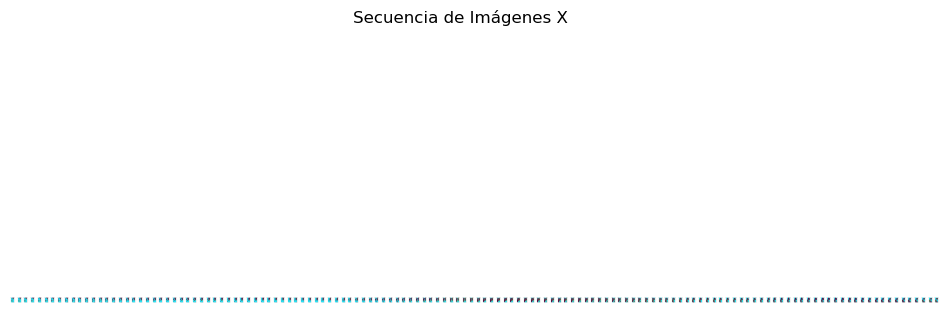

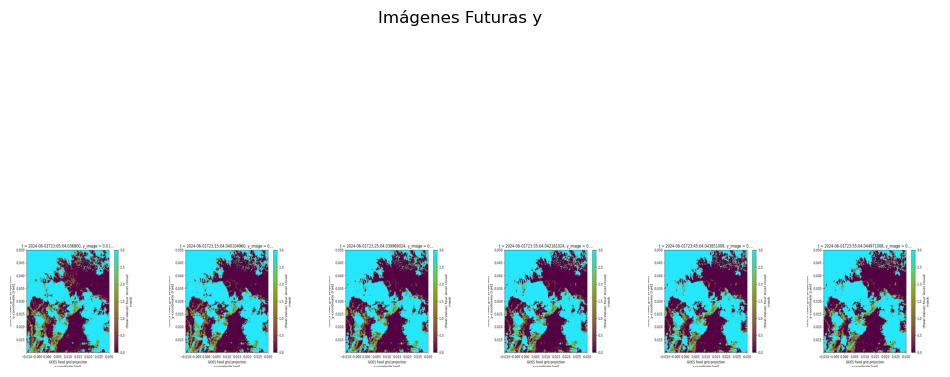

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


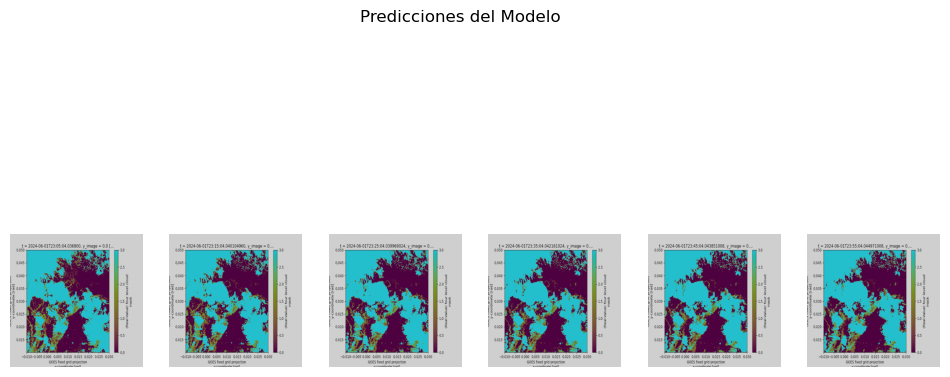

In [40]:
# Cargar secuencias de imágenes
X, y = load_image_sequences(image_folder, sequence_length, future_steps)

if X.size == 0 or y.size == 0:
    print("No se encontraron secuencias de imágenes válidas.")
else:
    # Extraer features usando VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
    flatten_layer = Flatten()(base_model.output)
    feature_extractor = Model(inputs=base_model.input, outputs=flatten_layer)

    def extract_features(image_sequences):
        num_sequences = image_sequences.shape[0]
        features = np.zeros((num_sequences, sequence_length, feature_extractor.output_shape[1]))

        for i in range(num_sequences):
            for j in range(sequence_length):
                image = image_sequences[i, j]
                image = np.expand_dims(image, axis=0)  # Añadir dimensión del lote
                feature = feature_extractor.predict(image)
                features[i, j] = feature.squeeze()
        return features

    X_features = extract_features(X)

    # Modelo LSTM
    model = Sequential()
    model.add(LSTM(256, input_shape=(sequence_length, feature_extractor.output_shape[1]), return_sequences=True))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(future_steps * height * width * channels, activation='linear'))
    model.add(Reshape((future_steps, height, width, channels)))

    model.compile(optimizer='adam', loss='mse')
    model.summary()

    # Entrenar el modelo (ajustar validation_split si hay pocas muestras)
    validation_split = 0.2 if X_features.shape[0] > 1 else 0.0
    if validation_split > 0:
        history = model.fit(X_features, y, epochs=30, batch_size=32, validation_split=validation_split)
    else:
        history = model.fit(X_features, y, epochs=30, batch_size=32)

    # Realizar predicciones
    def make_predictions(model, X_features):
        y_pred = model.predict(X_features)
        return y_pred

    # Guardar imágenes futuras
    def save_images(images, folder, original_filenames, suffix='_pred'):
        num_sequences, future_steps, height, width, channels = images.shape
        for i in range(num_sequences):
            for j in range(future_steps):
                image = images[i, j]
                original_filename = os.path.basename(original_filenames[i + sequence_length + j])  # Extraer solo el nombre de archivo
                base, ext = os.path.splitext(original_filename)
                new_filename = f"{base}{suffix}{ext}"
                new_filepath = os.path.join(folder, new_filename)
                image = (image * 255).astype('uint8')  # Desnormalizar
                cv2.imwrite(new_filepath, image)
                print(f"Guardada imagen: {new_filepath}")


    # Obtener predicciones
    y_pred = make_predictions(model, X_features)

    # Guardar las imágenes futuras predichas en 'Images/Forecast'
    save_images(y_pred, forecast_folder, image_files)

    # Función para visualizar imágenes
    def mostrar_imagenes(imagenes, titulo):
        plt.figure(figsize=(12, 6))
        for i in range(imagenes.shape[0]):
            plt.subplot(1, imagenes.shape[0], i + 1)
            plt.imshow(imagenes[i])
            plt.axis('off')
        plt.suptitle(titulo)
        plt.show()

    # Visualizar algunas imágenes de entrada y predicciones
    indice_secuencia = 0  # Cambia este índice para visualizar diferentes secuencias
    mostrar_imagenes(X[indice_secuencia], titulo='Secuencia de Imágenes X')
    mostrar_imagenes(y[indice_secuencia], titulo='Imágenes Futuras y')
    mostrar_imagenes(y_pred[indice_secuencia], titulo='Predicciones del Modelo')